# **Group 4 Final Project: Sentiment analysis of suicide ideation on social media PART3**
    Jin Chen / Kerin Wu / Minh Khoi Quach / Rhyon Tze Han Lu 2024-12



## Basic Setup

In [ ]:
# Import all necessary libraries
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize,PunktSentenceTokenizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_score, recall_score, roc_auc_score, log_loss, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
!pip install wordcloud
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import Counter
import time
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

!pip install contractions
import contractions

!pip install autocorrect
from autocorrect import Speller

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Dataset "Suicide Watch"

## Data Preprocessing
    The dataset has 348,124 reddit posts, 1 empty text, 14 empty labels and completely balanced.

In [ ]:
# Read in dataset B
data=pd.read_csv('SuicideAndDepression_Detection.csv')
data

,text,class
0,Does life actually work for most / non-depress...,depression
1,I found my friend's bodyIt was almost nine yea...,depression
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch
3,Am I weird I don't get affected by compliments...,teenagers
4,Finally 2020 is almost over... So I can never ...,teenagers
...,...,...
348119,You how you can tell i have so many friends an...,teenagers
348120,pee probably tastes like salty tea😏💦‼️ can som...,teenagers
348121,The usual stuff you find hereI'm not posting t...,SuicideWatch
348122,"I confronted my mother. Extremely isolated, wi...",depression


#### Checking shape, null, class distribution

In [ ]:
# check how many posts in this dataset
data.shape

(348124, 2)

In [ ]:
# check how many labels and what are the unique labels
data['class'].value_counts()

class
SuicideWatch    116037
teenagers       116037
depression      116036
Name: count, dtype: int64

In [ ]:
# check null values
data.isnull().sum()

text      1
class    14
dtype: int64

### Text Cleaning

In [ ]:
# Create a copy of data with stratified sampling for 10% of original dataset, equal pecentage for each class
df = data.copy()

# Handling null data
df = df.dropna(subset=['text', 'class'])
df = df[df['text'].str.strip() != '']
df = df[df['class'].str.strip() != '']

# Change the column name from 'class' to label'
df = df.rename(columns={'class': 'label'})

# Replace 'teenagers' with 'non-suicide', 'SuicideWatch' with 'suicide' in column label
df['label'] = df['label'].replace({'teenagers': 'non-suicide', 'SuicideWatch': 'suicide'})

# Remove HTML in the text column
df['cleaned_text'] = df['text'].str.replace(r'<[^<>]*>', '', regex=True)

# Remove new lines in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', ' ')

# Remove URLs in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove special characters (including emojis) with space in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# Convert the 'cleaned_text' column to string type to ensure all values are strings
df['cleaned_text'] = df['cleaned_text'].astype(str)

# Replacing contractions using contraction dictionary
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: contractions.fix(x))

# Remove english stopwords with nltk, except for 'I'
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('i')

# Remove custom stopwords as navigation or command terms, system feedback words, common internet slang
simple_stopwords = set([
    'ok', 'like and share', 'followers', 'repost', 'click', 'press', 'enter', 'submit', 'loading', 'processing', 'completed',
    'lol', 'lmao', 'btw', 'brb', 'fb', 'Welp'])
stop_words.update(simple_stopwords)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Add a space in a word with capital letter in between, e.g bodyIt
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x))

# Convert words to singular
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Apply negation tagging
#df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\b(?:not|n\'t)\b', 'not_', x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import cupy as cp

# Check CuPy version and CUDA availability
print("CuPy version:", cp.__version__)
print("CUDA available:", cp.cuda.is_available())

# Get GPU properties
device_id = 0  # Select the first GPU
props = cp.cuda.runtime.getDeviceProperties(device_id)

# Print GPU name
print("GPU Name:", props['name'])


CuPy version: 13.3.0
CUDA available: True
GPU Name: b'NVIDIA GeForce RTX 4080 SUPER'


In [ ]:
import spacy
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

nlp = spacy.load('en_core_web_sm')
nlp.select_pipes(enable=['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer'])

def process_batch(batch):
    docs = nlp.pipe(batch)
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

def parallel_lemmatize(texts, batch_size=1000, max_workers=4):
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(process_batch, batches),
            total=len(batches)
        ))

    return [item for batch in results for item in batch]

df['cleaned_text'] = parallel_lemmatize(df['cleaned_text'].tolist())

100%|██████████| 349/349 [10:29<00:00,  1.80s/it]


In [ ]:
df

,text,label,cleaned_text
0,Does life actually work for most / non-depress...,depression,life actually work nondepresse people it seem ...
1,I found my friend's bodyIt was almost nine yea...,depression,I find friend body it almost nine year ago I s...
2,Ex Wife Threatening SuicideRecently I left my ...,suicide,Ex Wife threaten Suicide recently I leave wife...
3,Am I weird I don't get affected by compliments...,non-suicide,I weird I get affect compliment come someone I...
4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 almost I never hear 2020 bad year...
...,...,...,...
348119,You how you can tell i have so many friends an...,non-suicide,tell I many friend lonely everything deprive I...
348120,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea someone drin...
348121,The usual stuff you find hereI'm not posting t...,suicide,usual stuff find here I m post sympathy pity I...
348122,"I confronted my mother. Extremely isolated, wi...",depression,I confront mother extremely isolated think hey...


### Try some examples after cleaning

In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - emojis
df[df['text'].str.contains("pee probably tastes like salty tea", na=False)]

,text,label,cleaned_text
348120,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea someone drin...


In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - html/URL links
df[df['text'].str.contains("http://imgur.com/xtAMc3x", na=False)]

,text,label,cleaned_text
58237,I baked muffins todayIt may seem like a stupid...,depression,I bake muffin today it may seem like stupid li...


## Word Embeddings using GloVe

In [ ]:
import numpy as np
from tqdm import tqdm
import mmap
import os

def load_glove_model_optimized(glove_file, batch_size=10000, verbose=True):
    """
    Load GloVe embeddings with batch processing and memory optimization

    Args:
        glove_file (str): Path to GloVe embeddings file
        batch_size (int): Number of vectors to process in each batch
        verbose (bool): Whether to show progress bars and info
    """
    # Get file size and count lines for progress bar
    file_size = os.path.getsize(glove_file)

    if verbose:
        print(f"Loading GloVe file: {glove_file}")
        print(f"File size: {file_size / 1024 / 1024:.2f} MB")

    # Pre-count lines for accurate progress bar
    with open(glove_file, 'r', encoding='utf8') as f:
        mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
        num_lines = sum(1 for _ in iter(mm.readline, b''))
        mm.close()

    if verbose:
        print(f"Total vectors to load: {num_lines}")

    embeddings_index = {}
    vectors_loaded = 0
    batch_vectors = []

    with open(glove_file, 'r', encoding='utf8') as f:
        # Memory map the file for faster reading
        mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)

        pbar = tqdm(total=num_lines, disable=not verbose)

        while True:
            line = mm.readline()
            if not line:  # EOF
                break

            try:
                line = line.decode('utf8')
                values = line.rstrip().split(' ')
                word = values[0]

                # Convert directly to numpy array, skipping intermediate list
                vector = np.fromiter(map(float, values[1:]), dtype=np.float32)

                batch_vectors.append((word, vector))
                vectors_loaded += 1

                # Process batch
                if len(batch_vectors) >= batch_size:
                    for w, v in batch_vectors:
                        embeddings_index[w] = v
                    batch_vectors = []

                    if verbose:
                        pbar.update(batch_size)

            except Exception as e:
                if verbose:
                    print(f"Error processing line: {e}")
                continue

        # Process remaining vectors
        for w, v in batch_vectors:
            embeddings_index[w] = v

        pbar.close()
        mm.close()

    if verbose:
        print(f"\nLoading complete!")
        print(f"Total vectors loaded: {vectors_loaded}")
        print(f"Vocabulary size: {len(embeddings_index)}")

        # Print memory usage
        import sys
        memory_size = sys.getsizeof(embeddings_index) / 1024 / 1024
        print(f"Memory usage: {memory_size:.2f} MB")

        # Print sample vector
        if embeddings_index:
            sample_word = next(iter(embeddings_index))
            print(f"\nSample vector for word '{sample_word}':")
            print(f"Vector shape: {embeddings_index[sample_word].shape}")

    return embeddings_index

# Usage example:
# glove_path = 'glove.6B.300d.txt'
# embeddings_index = load_glove_model_optimized(glove_path, batch_size=10000, verbose=True)

In [ ]:
glove_path = 'glove.6B.300d.txt'
embeddings_index = load_glove_model_optimized(
    glove_path,
    batch_size=10000,  # Adjust based on your available RAM
    verbose=True
)

Loading GloVe file: glove.6B.300d.txt
File size: 989.88 MB
Total vectors to load: 400000


100%|██████████| 400000/400000 [00:14<00:00, 27463.35it/s]


Loading complete!
Total vectors loaded: 400000
Vocabulary size: 400000
Memory usage: 14.67 MB

Sample vector for word 'the':
Vector shape: (300,)


In [ ]:
def create_preprocessing_model(df, embeddings_index, embedding_dim=300, sequence_length=200):
    """
    Pure NumPy implementation of text preprocessing and embedding
    """
    # Create vocabulary
    all_words = []
    for text in df['cleaned_text']:
        all_words.extend(text.split())

    # Words that appear more than once
    word_counts = Counter(all_words)
    vocab_words = [word for word, count in word_counts.items() if count > 1]

    # Word to index mapping
    word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab_words)}  # 0 for padding
    vocab_size = len(word_to_idx) + 1

    # Create sequences
    sequences = []
    for text in df['cleaned_text']:
        sequence = [word_to_idx.get(word, 0) for word in text.split()]
        sequences.append(sequence)

    # Pad sequences
    padded_sequences = np.zeros((len(sequences), sequence_length), dtype=np.int32)
    for i, seq in enumerate(sequences):
        if len(seq) > sequence_length:
            padded_sequences[i, :] = seq[:sequence_length]
        else:
            padded_sequences[i, :len(seq)] = seq

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return padded_sequences, embedding_matrix, word_to_idx

# Example of loading embeddings (e.g., GloVe, Word2Vec)
embeddings_index = {}  # Example: {word: vector}
# Load embeddings into embeddings_index as a dictionary

# Prepare data
padded_sequences, embedding_matrix, word_to_idx = create_preprocessing_model(df, embeddings_index)


## BiLSTM on GloVe

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset


# Convert labels to integers using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])  # Replace 'label' with your column name

# Convert to PyTorch tensors
X = torch.tensor(padded_sequences, dtype=torch.long)  # Input sequences
y = torch.tensor(labels, dtype=torch.long)           # Encoded labels

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]  # Last time-step output
        output = self.fc(last_out)
        return output

# Initialize model
hidden_size = 256  # Increased
num_layers = 3  # Increased
output_size = len(np.unique(labels))  # Number of classes
dropout = 0.2  # Tuned
learning_rate = 0.001  # Initial learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = LSTMModel(embedding_matrix, hidden_size, num_layers, output_size, dropout).to(device)


Using device: cuda


In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
criterion = nn.CrossEntropyLoss()  # Define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        """
        Early stopping to stop training when validation loss doesn't improve.
        :param patience: Number of epochs to wait before stopping.
        :param min_delta: Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def check(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Trigger early stopping
            return False

# Training Loop with Softmax Probabilities
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training Loop with tqdm
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, targets in train_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Raw logits
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loader_tqdm.set_postfix(train_loss=loss.item())

        # Validation Loop with Softmax Probabilities
        model.eval()
        test_loss = 0.0
        all_targets = []
        all_predictions = []
        all_probabilities = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Logits
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                # Apply softmax to get probabilities
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                predictions = torch.argmax(outputs, dim=1)  # Argmax of logits

                # Store predictions and probabilities for analysis
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Calculate average loss
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

        # Print Validation Loss
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Check Early Stopping
        if early_stopping.check(test_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return history, np.array(all_targets), np.array(all_predictions), np.array(all_probabilities)

# Train the model and get predictions
history, all_targets, all_predictions, all_probabilities = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, epochs=10, patience=3
)

# Calculate Accuracy
accuracy = (all_targets == all_predictions).mean()
print(f"\nTest Accuracy: {accuracy:.4f}")

# Display sample predictions and probabilities
for i in range(5):  # Display 5 sample outputs
    print(f"Sample {i+1}:")
    print(f"  True Label: {all_targets[i]}")
    print(f"  Predicted Label: {all_predictions[i]}")
    print(f"  Probabilities: {all_probabilities[i]}")


Epoch 1/10, Train Loss: 1.0331, Test Loss: 0.6454


Epoch 2/10, Train Loss: 0.5734, Test Loss: 0.4754


Epoch 3/10, Train Loss: 0.4250, Test Loss: 0.4401


Epoch 4/10, Train Loss: 0.3748, Test Loss: 0.4366


Epoch 5/10, Train Loss: 0.3321, Test Loss: 0.4573


Epoch 6/10, Train Loss: 0.2906, Test Loss: 0.4849


Epoch 7/10, Train Loss: 0.2526, Test Loss: 0.5192
Early stopping triggered at epoch 7

Test Accuracy: 0.7996
Sample 1:
  True Label: 2
  Predicted Label: 2
  Probabilities: [3.1201234e-01 2.5198868e-04 6.8773562e-01]
Sample 2:
  True Label: 2
  Predicted Label: 2
  Probabilities: [3.1075908e-02 5.4023392e-04 9.6838391e-01]
Sample 3:
  True Label: 0
  Predicted Label: 0
  Probabilities: [9.7956192e-01 5.4278370e-04 1.9895248e-02]
Sample 4:
  True Label: 2
  Predicted Label: 2
  Probabilities: [6.1483134e-02 3.4510100e-04 9.3817174e-01]
Sample 5:
  True Label: 2
  Predicted Label: 0
  Probabilities: [8.9579260e-01 4.1301353e-04 1.0379434e-01]


Getting predictions: 100%|██████████| 2176/2176 [00:21<00:00, 101.13it/s]



Classification Report:
              precision    recall  f1-score   support

  depression       0.78      0.66      0.71     23103
 non-suicide       0.92      0.92      0.92     23251
     suicide       0.71      0.82      0.76     23268

    accuracy                           0.80     69622
   macro avg       0.80      0.80      0.80     69622
weighted avg       0.80      0.80      0.80     69622



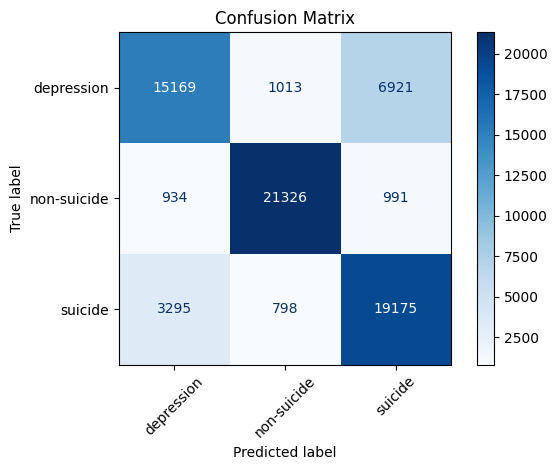

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Ensure the model is on the correct device
model.to(device)
model.eval()

# Initialize lists for predictions and true labels
y_pred = []
y_true = []

# Get all predictions
with torch.no_grad():
    for sequences, labels in tqdm(test_loader, desc="Getting predictions"):
        # Move data to GPU
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)  # Get class predictions

        # Store predictions and labels
        y_pred.extend(predicted.cpu().numpy())  # Move to CPU for NumPy compatibility
        y_true.extend(labels.cpu().numpy())

# Decode class names using label encoder
class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=class_names,
    cmap='Blues'
)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


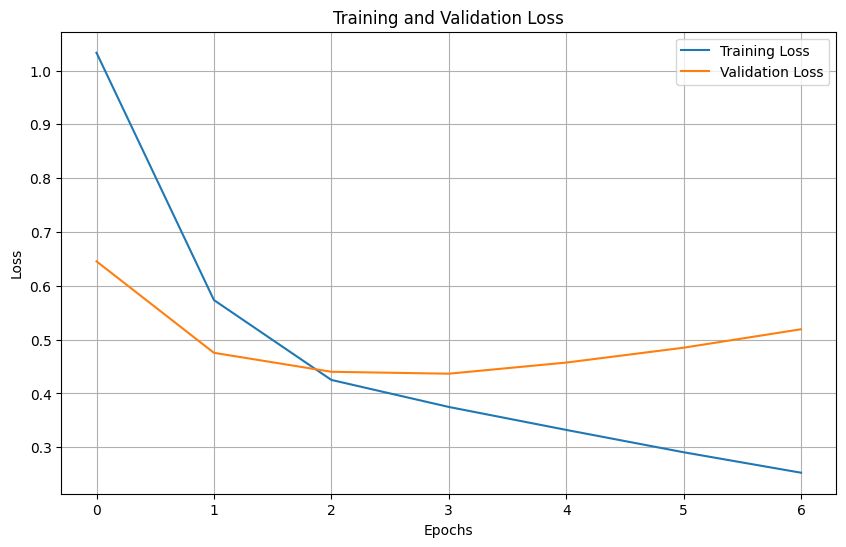

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Testing input

In [ ]:
# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.discard('i')

# Custom stopwords
simple_stopwords = set([
    'ok', 'like and share', 'followers', 'repost', 'click', 'press', 'enter', 'submit',
    'loading', 'processing', 'completed', 'lol', 'lmao', 'btw', 'brb', 'fb', 'Welp'
])
stop_words.update(simple_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    """
    Cleans input text based on multiple steps.
    """
    if not isinstance(text, str):
        return ""  # Handle non-string inputs gracefully

    # Remove HTML tags
    text = re.sub(r'<[^<>]*>', '', text)
    # Remove new lines
    text = text.replace('\n', ' ')
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove special characters and emojis
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Replace contractions
    text = contractions.fix(text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    # Add spaces in camelCase words
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    # Lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text.strip()

# Example test input
test_text = [
    "I feel so lost and hopeless.",
    "Life is getting better every day!",
    "Nothing ever works out for me.",
    "I am grateful for all the good things in life.",
    "Here's a link: http://example.com and <div>HTML content</div>!"
]

# Apply the cleaning function
cleaned_test_text = [clean_text(text) for text in test_text]


In [ ]:
import torch
import numpy as np


# Step 1: Preprocess the test text
def preprocess_input_text(text_list, word_to_idx, sequence_length=200):
    """
    Preprocess test text into padded sequences using word_to_idx.
    """
    # Apply cleaning
    cleaned_texts = [clean_text(text) for text in text_list]

    # Convert to sequences
    sequences = []
    for text in cleaned_texts:
        sequence = [word_to_idx.get(word, 0) for word in text.split()]  # Unknown words map to 0
        sequences.append(sequence)

    # Pad sequences
    padded_sequences = np.zeros((len(sequences), sequence_length), dtype=np.int32)
    for i, seq in enumerate(sequences):
        if len(seq) > sequence_length:
            padded_sequences[i, :] = seq[:sequence_length]
        else:
            padded_sequences[i, :len(seq)] = seq

    return torch.tensor(padded_sequences, dtype=torch.long)

# Preprocess the input test text
input_sequences = preprocess_input_text(test_text, word_to_idx)

# Step 2: Move to device (CPU or GPU)
input_sequences = input_sequences.to(device)

# Step 3: Set model to evaluation mode and make predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():
    outputs = model(input_sequences)  # Forward pass
    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
    predicted_classes = torch.argmax(probabilities, dim=1)  # Get the class with highest probability

# Step 4: Decode predicted classes back to label names
predicted_labels = label_encoder.inverse_transform(predicted_classes.cpu().numpy())

# Step 5: Display predictions
print("Predictions:")
for i, text in enumerate(test_text):
    print(f"Input: '{text}'")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Probabilities: {probabilities[i].cpu().numpy()}\n")


Predictions:
Input: 'I feel so lost and hopeless.'
Predicted Label: suicide
Probabilities: [0.28324312 0.04295564 0.6738012 ]

Input: 'Life is getting better every day!'
Predicted Label: non-suicide
Probabilities: [0.14290014 0.5814213  0.2756786 ]

Input: 'Nothing ever works out for me.'
Predicted Label: suicide
Probabilities: [0.24607407 0.30803123 0.44589475]

Input: 'I am grateful for all the good things in life.'
Predicted Label: non-suicide
Probabilities: [0.06745195 0.860873   0.07167509]

Input: 'Here's a link: http://example.com and <div>HTML content</div>!'
Predicted Label: non-suicide
Probabilities: [0.00832331 0.98711383 0.00456279]



In [ ]:
df['cleaned_text']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import DebertaV2Tokenizer

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Label encoding
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Step 2: Tokenization
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], truncation=True, padding="max_length", max_length=128)

# Convert train_df and test_df into Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label_encoded']])
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'label_encoded']])

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label_encoded' column to 'labels' (Trainer expects this)
train_dataset = train_dataset.rename_column("label_encoded", "labels")
test_dataset = test_dataset.rename_column("label_encoded", "labels")

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(['cleaned_text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['cleaned_text', '__index_level_0__'])



In [ ]:
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label_encoded']])
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'label_encoded']])

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename the column to 'labels'
train_dataset = train_dataset.rename_column("label_encoded", "labels")
test_dataset = test_dataset.rename_column("label_encoded", "labels")

# Remove unused columns
train_dataset = train_dataset.remove_columns(['cleaned_text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['cleaned_text', '__index_level_0__'])


In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
# Step 5: Hugging Face Trainer
model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(label_encoder.classes_)

# Step 4: Training Arguments with Early Stopping
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,          # Set a high epoch limit; early stopping will stop it earlier if needed
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=2,           # Limit the number of saved checkpoints
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    greater_is_better=True,       # Higher accuracy is better
)

# Step 5: Define Compute Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

# Step 6: Trainer Initialization with Early Stopping Callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 evals
)

# Step 7: Train and Evaluate
print("Starting training...")
trainer.train()

print("Evaluating the model...")
results = trainer.evaluate()
print(f"Results: {results}")

# Save th


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Step 1: Make Predictions
print("Predicting on the test dataset...")
predictions = trainer.predict(test_dataset)

# Step 2: Extract Predicted Labels and True Labels
preds = np.argmax(predictions.predictions, axis=1)  # Predicted labels
labels = predictions.label_ids  # True labels

# Step 3: Compute the Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Step 4: Generate a Classification Report
class_report = classification_report(labels, preds, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)

# Optional: Display Confusion Matrix as a Pandas DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print("\nConfusion Matrix as DataFrame:")
print(conf_matrix_df)


# Dataset "Mental Illness"

In [ ]:
df2=pd.read_csv('mentalillness.csv')
df2

In [ ]:
df2['label'].value_counts()

In [ ]:
df2.rename(columns={'text': 'text', 'label': 'label'}, inplace=True)

# Drop rows with missing values in text or label columns
df2 = df2.dropna(subset=['text', 'label'])

# Split the dataset into train and test sets (80-20 split)
train_data, test_data = train_test_split(df2, test_size=0.2, random_state=42)

In [ ]:
from transformers import DistilBertTokenizerFast

# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
def preprocess_data(data):
    return tokenizer(
        list(data['text']),           # Input text
        truncation=True,              # Truncate sequences to max length
        padding=True,                 # Pad sequences to the same length
        max_length=512,               # Maximum token length
        return_tensors="pt"           # Return PyTorch tensors
    )

# Tokenize the train and test datasets
train_encodings = preprocess_data(train_data)
test_encodings = preprocess_data(test_data)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels2 = label_encoder.fit_transform(train_data['label'])
test_labels2 = label_encoder.transform(test_data['label'])

In [ ]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Use the original tensors directly instead of wrapping with torch.tensor
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Only wrap labels if they aren't tensors
        return item

# Prepare the datasets
train_dataset2 = TextDataset(train_encodings, train_labels2)
test_dataset2 = TextDataset(test_encodings, test_labels2)


In [ ]:
from transformers import DistilBertForSequenceClassification

# Number of unique labels
num_labels = len(label_encoder.classes_)

# Load the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


In [ ]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="./results",            # Directory to save the model
    eval_strategy="epoch",             # Evaluate after each epoch
    save_strategy="epoch",             # Save the model after each epoch
    logging_dir="./logs",              # Directory for logs
    learning_rate=5e-5,                # Learning rate
    per_device_train_batch_size=16,    # Training batch size
    per_device_eval_batch_size=16,     # Evaluation batch size
    num_train_epochs=20,               # Increase the total number of epochs
    weight_decay=0.01,                 # Weight decay
    logging_steps=10,                  # Log every 10 steps
    load_best_model_at_end=True,       # Load the best model at the end
    metric_for_best_model="accuracy",  # Metric for choosing the best model
    greater_is_better=True             # Specify whether higher metric values are better
)



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Define the function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
from transformers import EarlyStoppingCallback

# Define the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Number of epochs with no improvement to wait before stopping
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset2,
    eval_dataset=test_dataset2,
    compute_metrics=compute_metrics,   # Metrics function
    callbacks=[early_stopping_callback]  # Add early stopping callback
)

In [ ]:
trainer.train()
trainer.evaluate()

In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
print(classification_report(test_labels, preds))

## BERT

In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer

# Step 1: Load the saved model and tokenizer
model_dir = "DatasetC"  # Path to your saved model directory

# Load the classification model and tokenizer
bert_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

print("BERT Model and Tokenizer Loaded Successfully!")

# Step 2: Define new test input data
test_sentences = [
    "I feel so overwhelmed and hopeless.",
    "Life is tough, but I’m hanging in there.",
    "I’m so happy today, everything feels perfect!",
    "Why does nothing ever work out for me?",
    "I can’t stop crying; I feel so lost.",
    "Things have been hard lately, but I’m trying my best.",
    "I feel empty, like there’s no point in anything anymore.",
    "I’m excited about the future and all its possibilities!",
    "I don’t know how to ask for help, but I need it.",
    "Today is a new day, and I feel ready to take on challenges.",
    "I feel trapped, like there’s no way out.",
    "I’m grateful for the little joys in life.",
    "I don’t think I can keep doing this much longer.",
    "I’m learning to appreciate myself and my progress.",
    "My friends and family make me feel so supported.",
    "I feel like a failure, no matter what I do.",
    "I want to make changes in my life, but I don’t know how.",
    "I can’t shake this constant feeling of sadness.",
    "I’m hopeful that tomorrow will be better than today.",
    "It’s hard to see the light at the end of the tunnel."
]

# Step 3: Create a Hugging Face Dataset for testing
test_data = Dataset.from_dict({"input_text": test_sentences})

# Step 4: Tokenize the input text
def tokenize_test_data(examples):
    return bert_tokenizer(examples["input_text"], truncation=True, padding="max_length", max_length=128)

tokenized_test_data = test_data.map(tokenize_test_data, batched=True)
tokenized_test_data = tokenized_test_data.remove_columns(["input_text"])

# Step 5: Initialize the Trainer with the loaded BERT model
bert_trainer = Trainer(model=bert_model)

# Step 6: Make predictions using the Trainer
bert_predictions = bert_trainer.predict(tokenized_test_data)

# Step 7: Extract logits and calculate softmax probabilities
bert_logits = bert_predictions.predictions
bert_softmax_probs = torch.nn.functional.softmax(torch.tensor(bert_logits), dim=-1)

# Step 8: Determine predicted classes
bert_predicted_classes = torch.argmax(bert_softmax_probs, dim=-1)

# Step 9: Prepare a results table with renamed variables
results_table = []
for idx, sentence in enumerate(test_sentences):
    row = {
        "Test Sentence": sentence,
        "Predicted Class": bert_predicted_classes[idx].item(),
    }
    for i, prob in enumerate(bert_softmax_probs[idx]):
        row[f"Class {i} Probability"] = prob.item()
    results_table.append(row)

# Step 10: Display results in a DataFrame with new name
final_test_results = pd.DataFrame(results_table)
print("Test Results:")
print(final_test_results)

BERT Model and Tokenizer Loaded Successfully!


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Test Results:
                                        Test Sentence  Predicted Class  \
0                 I feel so overwhelmed and hopeless.                1   
1            Life is tough, but I’m hanging in there.                4   
2       I’m so happy today, everything feels perfect!                4   
3              Why does nothing ever work out for me?                4   
4                I can’t stop crying; I feel so lost.                4   
5   Things have been hard lately, but I’m trying m...                1   
6   I feel empty, like there’s no point in anythin...                4   
7   I’m excited about the future and all its possi...                1   
8    I don’t know how to ask for help, but I need it.                1   
9   Today is a new day, and I feel ready to take o...                0   
10           I feel trapped, like there’s no way out.                3   
11          I’m grateful for the little joys in life.                4   
12   I don’t think I can

In [ ]:
final_test_results

,Test Sentence,Predicted Class,Class 0 Probability,Class 1 Probability,Class 2 Probability,Class 3 Probability,Class 4 Probability,Class 5 Probability,Class 6 Probability,Class 7 Probability
0,I feel so overwhelmed and hopeless.,1,0.065957,0.421955,0.087963,0.125685,0.119094,0.006091,0.045561,0.127695
1,"Life is tough, but I’m hanging in there.",4,0.006570,0.059492,0.044995,0.056131,0.789948,0.001987,0.011792,0.029084
2,"I’m so happy today, everything feels perfect!",4,0.019630,0.237642,0.064298,0.243368,0.286027,0.003971,0.086714,0.058350
3,Why does nothing ever work out for me?,4,0.369648,0.074996,0.034113,0.028412,0.461583,0.002857,0.014999,0.013391
4,I can’t stop crying; I feel so lost.,4,0.006159,0.161655,0.022686,0.131047,0.633921,0.000951,0.009590,0.033992
5,"Things have been hard lately, but I’m trying m...",1,0.025027,0.367888,0.071599,0.051064,0.311571,0.004498,0.067270,0.101084
6,"I feel empty, like there’s no point in anythin...",4,0.002272,0.018542,0.013273,0.441107,0.499441,0.000213,0.004171,0.020981
7,I’m excited about the future and all its possi...,1,0.071053,0.230967,0.210833,0.086772,0.156113,0.027044,0.138827,0.078389
8,"I don’t know how to ask for help, but I need it.",1,0.053730,0.219179,0.165468,0.093324,0.168860,0.017008,0.081808,0.200623
9,"Today is a new day, and I feel ready to take o...",0,0.258414,0.213705,0.174208,0.085706,0.034526,0.019991,0.103648,0.109802


In [ ]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import mmap
import os

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load BERT Model (Mental Illness Detection) ---
bert_model_dir = "DatasetC"
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_dir)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_dir)
bert_trainer = Trainer(model=bert_model)
bert_model.eval()
print("BERT Model Loaded Successfully!")

# --- Load GloVe-BiLSTM Model (Suicidal Detection) ---
model.eval()
model = model.to(device)
print("GloVe-BiLSTM Model Loaded Successfully!")

# --- Load Saved LabelEncoder ---
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['depression', 'non-suicide', 'suicide'])  # Manually set classes
print(f"Loaded LabelEncoder Classes: {list(label_encoder.classes_)}")

# --- BERT Class Key ---
bert_class_key = {
    0: "ADHD", 1: "Anxiety", 2: "Bipolar Disorder", 3: "BPD",
    4: "Depression", 5: "None", 6: "OCD", 7: "PTSD"
}

# --- Optimized GloVe Loader ---
def load_glove_model_optimized(glove_file, batch_size=10000):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
        pbar = tqdm(total=os.path.getsize(glove_file), desc="Loading GloVe")
        while True:
            line = mm.readline()
            if not line: break
            values = line.decode('utf8').rstrip().split()
            word, vector = values[0], np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = vector
            pbar.update(len(line))
        pbar.close()
    return embeddings_index

# --- Create Word-to-Index Mapping and Embedding Matrix ---
def create_embedding_matrix(embeddings_index, embedding_dim=300):
    word_to_idx = {'<unk>': 0}  # Unknown token
    embedding_matrix = [np.zeros(embedding_dim)]  # Row 0 for unknown words

    for idx, (word, vector) in enumerate(embeddings_index.items()):
        word_to_idx[word] = idx + 1  # Start indexing from 1
        embedding_matrix.append(vector)

    return word_to_idx, torch.tensor(np.vstack(embedding_matrix), dtype=torch.float32)

# --- Preprocessing for BiLSTM ---
def clean_text(text):
    """
    Simplified text cleaning for demonstration.
    """
    return text.lower().strip()

def preprocess_input_text(text_list, word_to_idx, sequence_length=200):
    """
    Preprocess test text into padded sequences using word_to_idx.
    """
    cleaned_texts = [clean_text(text) for text in text_list]
    sequences = [[word_to_idx.get(word, 0) for word in text.split()] for text in cleaned_texts]

    padded_sequences = np.zeros((len(sequences), sequence_length), dtype=np.int32)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :min(len(seq), sequence_length)] = seq[:sequence_length]
    return torch.tensor(padded_sequences, dtype=torch.long).to(device)

# --- Combined Prediction Pipeline ---
def combined_predict(text_list, word_to_idx, sequence_length=200):
    """
    Pipeline: BERT predicts type of mental illness -> BiLSTM predicts suicidal tendencies.
    """
    print("\n--- Step 1: BERT Mental Illness Type Detection ---")
    test_data = Dataset.from_dict({"input_text": text_list})
    tokenized_data = test_data.map(lambda x: bert_tokenizer(x["input_text"], truncation=True, padding="max_length", max_length=128), batched=True)
    tokenized_data = tokenized_data.remove_columns(["input_text"])

    # Predict using BERT
    bert_predictions = bert_trainer.predict(tokenized_data)
    bert_classes = torch.argmax(torch.nn.functional.softmax(torch.tensor(bert_predictions.predictions), dim=-1), dim=-1)

    print("\n--- Step 2: GloVe-BiLSTM Suicidal Detection ---")
    for i, text in enumerate(text_list):
        bert_prediction = bert_class_key[bert_classes[i].item()]
        print(f"\nInput: '{text}'")
        print(f"BERT Prediction: {bert_prediction}")

        if bert_prediction != "None":  # Skip if BERT predicts 'None'
            bilstm_input = preprocess_input_text([text], word_to_idx, sequence_length)
            with torch.no_grad():
                outputs = model(bilstm_input)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()

            # Decode predicted class using LabelEncoder
            decoded_label = label_encoder.inverse_transform([predicted_class])[0]
            print(f"BiLSTM Prediction: {decoded_label}")
            print(f"BiLSTM Probabilities: {probabilities[0].cpu().numpy()}")
        else:
            print("No mental illness detected. Skipping BiLSTM.")

# --- Load GloVe Embeddings ---
glove_path = 'glove.6B.300d.txt'
embeddings_index = load_glove_model_optimized(glove_path)
word_to_idx, embedding_matrix = create_embedding_matrix(embeddings_index)
print("GloVe Embeddings Loaded and Processed Successfully!")

# --- Example Input ---
test_texts = [
    "I feel so overwhelmed and hopeless.",
    "Life is tough, but I’m hanging in there.",
    "I don’t see a reason to keep going.",
    "I’m so happy today, everything feels perfect!",
    "I can’t stop worrying about everything.",
    "I don’t want to live anymore.",
    "I'm constantly distracted and can't focus.",
    "I'm excited for the future and hopeful for change."
]

# Run Combined Prediction
combined_predict(test_texts, word_to_idx)

BERT Model Loaded Successfully!
GloVe-BiLSTM Model Loaded Successfully!
Loaded LabelEncoder Classes: ['depression', 'non-suicide', 'suicide']


Loading GloVe: 100%|██████████| 1037962819/1037962819 [00:15<00:00, 67742204.18it/s]


GloVe Embeddings Loaded and Processed Successfully!

--- Step 1: BERT Mental Illness Type Detection ---


Map:   0%|          | 0/8 [00:00<?, ? examples/s]


--- Step 2: GloVe-BiLSTM Suicidal Detection ---

Input: 'I feel so overwhelmed and hopeless.'
BERT Prediction: Anxiety
BiLSTM Prediction: depression
BiLSTM Probabilities: [0.9648393  0.00194447 0.03321617]

Input: 'Life is tough, but I’m hanging in there.'
BERT Prediction: Depression
BiLSTM Prediction: non-suicide
BiLSTM Probabilities: [0.00941327 0.9392973  0.05128944]

Input: 'I don’t see a reason to keep going.'
BERT Prediction: Depression
BiLSTM Prediction: suicide
BiLSTM Probabilities: [0.18132076 0.05465403 0.7640253 ]

Input: 'I’m so happy today, everything feels perfect!'
BERT Prediction: Depression
BiLSTM Prediction: non-suicide
BiLSTM Probabilities: [0.22848827 0.5513658  0.22014593]

Input: 'I can’t stop worrying about everything.'
BERT Prediction: Anxiety
BiLSTM Prediction: depression
BiLSTM Probabilities: [0.86966854 0.00242083 0.12791058]

Input: 'I don’t want to live anymore.'
BERT Prediction: Depression
BiLSTM Prediction: suicide
BiLSTM Probabilities: [0.03703805 0.009